In [1]:
from data_processer import *
import torch
from transformers import (
    PatchTSMixerConfig, 
    PatchTSMixerForTimeSeriesClassification,
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback,
 )
from transformers.utils import ModelOutput
from typing import Optional, Tuple, Union
from dataclasses import dataclass

2025-03-17 10:21:38.051968: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/ubuntu/anaconda3/envs/gpt/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/ubuntu/anaconda3/envs/g

In [2]:
data_path = "data"
ts_processor = TS_Processor(sequence_length=1024, stride=64, remove_extreme_values=True, iqr_threshold=10.0)
dataset_dict = ts_processor(data_path)

print(dataset_dict)

Detected and removed outliers:
File: 20nm_degree_40.csv, Index: 0, Data: {'time': '2024-12-04 16:14:39.579.', '2-1[m/s^2]': 29.76894, '2-2[m/s^2]': -990.73804, '2-3[m/s^2]': 2.5759, '2-4[m/s^2]': 1015.4796, '2-5[m/s^2]': 0.23558, '2-6[m/s^2]': 0.02296}
File: 100nm_degree_80.csv, Index: 0, Data: {'time': '2024-12-04 18:18:00.273.', '2-1[m/s^2]': 33.15849, '2-2[m/s^2]': 0.58145, '2-3[m/s^2]': -0.53943, '2-4[m/s^2]': -1014.426, '2-5[m/s^2]': -0.22313, '2-6[m/s^2]': 1003.5881}
File: 100nm_degree_40.csv, Index: 0, Data: {'time': '2024-12-04 16:27:52.112.', '2-1[m/s^2]': 31.60742, '2-2[m/s^2]': 991.20013, '2-3[m/s^2]': 1017.3141, '2-4[m/s^2]': 1015.8311, '2-5[m/s^2]': 1003.2505, '2-6[m/s^2]': -1.00929}
File: 60nm_degree_60.csv, Index: 0, Data: {'time': '2024-12-04 17:04:45.059.', '2-1[m/s^2]': -2.50719, '2-2[m/s^2]': -990.35828, '2-3[m/s^2]': 4.05837, '2-4[m/s^2]': 1013.4236, '2-5[m/s^2]': 1003.9898, '2-6[m/s^2]': -1002.5587}
File: 20nm_degree_60.csv, Index: 0, Data: {'time': '2024-12-04 17:

In [3]:
config = PatchTSMixerConfig(
    num_input_channels=len(dataset_dict["train"][0]["sequence"][0]), 
    num_targets=len(set(dataset_dict["train"]["label"])), 
    num_labels=len(set(dataset_dict["train"]["label"])),
    context_length=len(dataset_dict["train"][0]["sequence"]), 
    patch_length=16,
    patch_stride=16,
    d_model=80,               
    expansion_factor=2,
    num_layers=4,
    dropout=0.2,              
    mode="common_channel",       
    gated_attn=True,
    norm_mlp="LayerNorm",
    self_attn=False,
)

@dataclass
class Revised_PatchTSMixerForTimeSeriesClassificationOutput(ModelOutput):

    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    last_hidden_state: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None


class Revised_PatchTSMixerForTimeSeriesClassification(PatchTSMixerForTimeSeriesClassification):
    def forward(self, *args, **kwargs):
        outputs = super().forward(*args, **kwargs)
        
        return Revised_PatchTSMixerForTimeSeriesClassificationOutput(
            loss=outputs.loss,
            logits=outputs.prediction_outputs, 
         #   last_hidden_state=outputs.last_hidden_state, 
         #   hidden_states=outputs.hidden_states,
        )


model = Revised_PatchTSMixerForTimeSeriesClassification(config)

training_args = TrainingArguments(
    output_dir="./results_patchmixer",
    evaluation_strategy="steps", 
    eval_steps=200, 
    save_strategy="steps", 
    save_steps=200,
    learning_rate=5e-4,
    load_best_model_at_end=True, 
    metric_for_best_model="eval_loss", 
  #  greater_is_better=True, 
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=50,
    weight_decay=0.01,
    logging_dir="./logs_patchmixer",
    logging_steps=50,
    save_total_limit=2,
    label_names=["target_values"],
    remove_unused_columns=False
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=8)]
)

/home/ubuntu/anaconda3/envs/gpt/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [4]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,1.281200,1.022591,0.698531
400,0.563100,0.400531,0.885557
600,0.247400,0.164636,0.950796
800,0.143000,0.116076,0.960465
1000,0.111300,0.097490,0.965973
1200,0.091900,0.077746,0.973439
1400,0.086300,0.069723,0.974663
1600,0.074000,0.068269,0.974908
1800,0.056800,0.058603,0.978335
2000,0.054000,0.056090,0.979804


TrainOutput(global_step=13000, training_loss=0.06980540758600602, metrics={'train_runtime': 11816.3072, 'train_samples_per_second': 245.572, 'train_steps_per_second': 1.921, 'total_flos': 1.5032216549376e+16, 'train_loss': 0.06980540758600602, 'epoch': 28.634361233480178})

In [7]:
test_results = trainer.evaluate(eval_dataset=dataset_dict["test"])
test_results

{'eval_loss': 0.06192333251237869,
 'eval_accuracy': 0.9828318369327833,
 'eval_runtime': 92.945,
 'eval_samples_per_second': 177.352,
 'eval_steps_per_second': 1.388,
 'epoch': 28.634361233480178}

In [8]:
model.num_parameters()

245375

Plot saved to ./plot/patchmixer_result.pdf


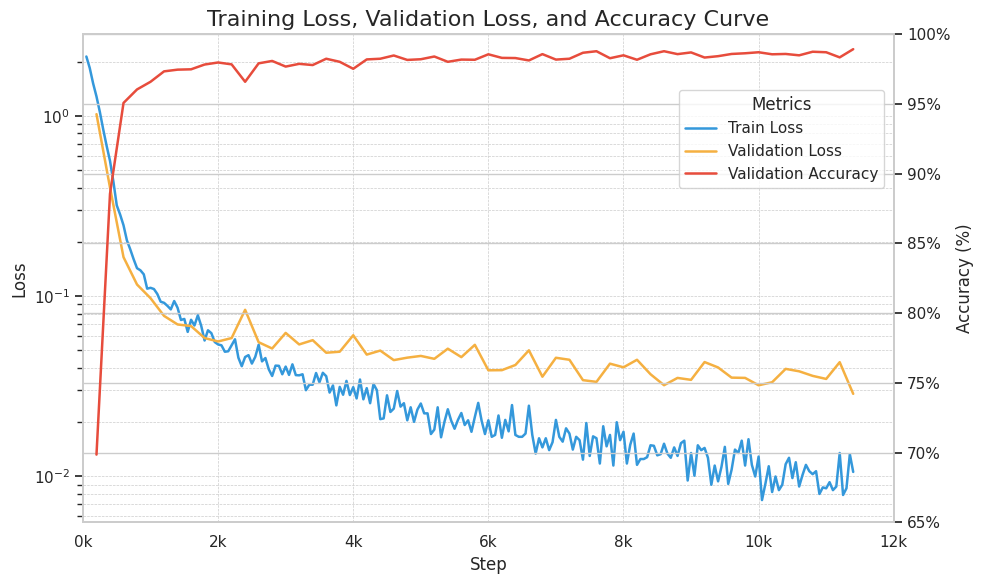

In [1]:
from plot_results import plot_training_results

path = "results_patchmixer2/checkpoint-11400"
plot_training_results(checkpoint_path=path, save_plot=True, plot_name="patchmixer_result")